# GaMMA Synthetic Example

Applying GaMMA to associate synthetic picks

In [51]:
import pandas as pd
from datetime import datetime, timedelta
import gamma
from gamma import BayesianGaussianMixture, GaussianMixture
from gamma.utils import convert_picks_csv, association, from_seconds
import numpy as np
from sklearn.cluster import DBSCAN
from datetime import datetime, timedelta
import os
import json
import pickle
from tqdm import tqdm
import time


In [52]:
data_path = lambda x: os.path.join("./", x)
station_csv = data_path("synthetic_stations.csv")
pick_json = data_path("synthetic_picks.json")
pick_csv = data_path("synthetic_picks.csv")
catalog_csv = data_path("catalog_gamma.csv")
picks_csv = data_path("picks_gamma.csv")
if not os.path.exists("figures"):
    os.makedirs("figures")
figure_dir = lambda x: os.path.join("figures", x)

## read config
with open("config.json", "r") as f:
    config = json.load(f)
# config["x(km)"] = (np.array(config["xlim_degree"])-np.array(config["center"][0]))*config["degree2km"]
# config["y(km)"] = (np.array(config["ylim_degree"])-np.array(config["center"][1]))*config["degree2km"]
# config["z(km)"] = (0, 20)

## read picks
# picks = pd.read_json(pick_json)
picks = pd.read_csv(pick_csv, sep="\t")
picks["timestamp"] = picks["timestamp"].apply(lambda x: datetime.fromisoformat(x))
picks["time_idx"] = picks["timestamp"].apply(
    lambda x: x.strftime("%Y-%m-%dT%H")
)  ## process by hours
picks["id"] = picks["station_id"]

## read stations
stations = pd.read_csv(station_csv, sep="\t")
stations.rename(columns={"station": "id"}, inplace=True)
stations["x(km)"] = stations["longitude"].apply(
    lambda x: (x - config["center"][0]) * config["degree2km"]
)
stations["y(km)"] = stations["latitude"].apply(
    lambda x: (x - config["center"][1]) * config["degree2km"]
)
stations["z(km)"] = stations["elevation(m)"].apply(lambda x: -x / 1e3)

## set GMMA configs
config["starttime"] = picks["timestamp"].min()
config["endtime"] = picks["timestamp"].max()
config["dims"] = ['x(km)', 'y(km)', 'z(km)']
config["use_dbscan"] = True
config["use_amplitude"] = True
config["vel"] = {"p": 6.0, "s": 6.0 / 1.75}
config["method"] = "BGMM"
if config["method"] == "BGMM":
    config["oversample_factor"] = 3
if config["method"] == "GMM":
    config["oversample_factor"] = 1

# config["oversample_factor"] = 3

# DBSCAN
config["bfgs_bounds"] = (
    (config["x(km)"][0] - 1, config["x(km)"][1] + 1),  # x
    (config["y(km)"][0] - 1, config["y(km)"][1] + 1),  # y
    (0, config["z(km)"][1] + 1),  # x
    (None, None),  # t
)
config["dbscan_eps"] = min(
    6, #seconds
    np.sqrt(
        (stations["x(km)"].max() - stations["x(km)"].min()) ** 2
        + (stations["y(km)"].max() - stations["y(km)"].min()) ** 2
    )
    / (6.0 / 1.75),
)
config["dbscan_min_samples"] = min(3, len(stations))

# Filtering
config["min_picks_per_eq"] = min(10, len(stations) // 2)
config["max_sigma11"] = 1.0 * 2.0
config["max_sigma22"] = 0.5 * 2.0

for k, v in config.items():
    print(f"{k}: {v}")


center: [-117.504, 35.705]
xlim_degree: [-118.004, -117.004]
ylim_degree: [35.205, 36.205]
zlim_km: [0, 20]
degree2km: 111.19492474777779
x(km): [-55.597462373888895, 55.597462373888895]
y(km): [-55.597462373888895, 55.597462373888895]
z(km): [0, 20]
starttime: 2019-01-01 00:00:01.961000
endtime: 2019-01-01 00:08:28.318000
dims: ['x(km)', 'y(km)', 'z(km)']
use_dbscan: True
use_amplitude: True
vel: {'p': 6.0, 's': 3.4285714285714284}
method: BGMM
oversample_factor: 3
bfgs_bounds: ((-56.597462373888895, 56.597462373888895), (-56.597462373888895, 56.597462373888895), (0, 21), (None, None))
dbscan_eps: 6
dbscan_min_samples: 3
min_picks_per_eq: 10
max_sigma11: 2.0
max_sigma22: 1.0


## 2. Associaiton with GaMMA

In [53]:
start_time = time.time()
pbar = tqdm(sorted(list(set(picks["time_idx"]))))
event_idx0 = 0  ## current earthquake index
assignments = []
if (len(picks) > 0) and (len(picks) < 5000):
    data, locs, phase_type, phase_weight, phase_index = convert_picks_csv(
        picks, stations, config
    )
    catalogs, assignments = association(
        data,
        locs,
        phase_type,
        phase_weight,
        len(stations),
        phase_index,
        event_idx0,
        config,
        method=config["method"],
        pbar=pbar,
    )
    event_idx0 += len(catalogs)
else:
    catalogs = []
    for i, hour in enumerate(pbar):
        picks_ = picks[picks["time_idx"] == hour]
        if len(picks_) == 0:
            continue
        data, locs, phase_type, phase_weight, phase_index = convert_picks_csv(
            picks_, stations, config
        )
        catalog, assign = association(
            data,
            locs,
            phase_type,
            phase_weight,
            len(stations),
            phase_index,
            event_idx0,
            config,
            method=config["method"],
            pbar=pbar,
        )
        event_idx0 += len(catalog)
        catalogs.extend(catalog)
        assignments.extend(assign)

## create catalog
catalogs = pd.DataFrame(
    catalogs, columns=["time(s)"] + config["dims"] + ["magnitude", "sigma_time", "sigma_amp", "cov_time_amp", "event_idx", "prob_gamma"]
)
catalogs["time"] = catalogs["time(s)"].apply(lambda x: from_seconds(x))
catalogs["longitude"] = catalogs["x(km)"].apply(
    lambda x: x / config["degree2km"] + config["center"][0]
)
catalogs["latitude"] = catalogs["y(km)"].apply(
    lambda x: x / config["degree2km"] + config["center"][1]
)
catalogs["depth(m)"] = catalogs["z(km)"].apply(lambda x: x * 1e3)

with open(catalog_csv, 'w') as fp:
    catalogs.to_csv(
        fp,
        sep="\t",
        index=False,
        float_format="%.3f",
        date_format='%Y-%m-%dT%H:%M:%S.%f',
        columns=[
            "time",
            "magnitude",
            "longitude",
            "latitude",
            "depth(m)",
            "sigma_time",
            "sigma_amp",
            "cov_time_amp",
            "event_idx",
            "prob_gamma",
            "x(km)",
            "y(km)",
            "z(km)",
        ],
    )
catalogs = catalogs[
    ['time', 'magnitude', 'longitude', 'latitude', 'depth(m)', 'sigma_time', 'sigma_amp']
]

## add assignment to picks
assignments = pd.DataFrame(assignments, columns=["pick_idx", "event_idx", "prob_gamma"])
picks = (
    picks.join(assignments.set_index("pick_idx")).fillna(-1).astype({'event_idx': int})
)
with open(picks_csv, 'w') as fp:
    picks.to_csv(
        fp,
        sep="\t",
        index=False,
        date_format='%Y-%m-%dT%H:%M:%S.%f',
        columns=["id", "timestamp", "type", "prob", "amp", "event_idx", "prob_gamma"],
    )

print(f"Total time: {time.time() - start_time} seconds")


Total time: 93.03103137016296 seconds


## 3. Visualize results

Note that the location and magnitude are estimated during associaiton, which are not expected to have high accuracy. 

In [54]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

result_label = "GaMMA"
catalog_label = "True"


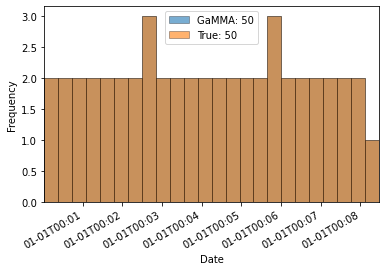

In [55]:
stations = pd.read_csv(data_path("synthetic_stations.csv"), delimiter="\t")
events = pd.read_csv(data_path("synthetic_events.csv"), delimiter="\t")
events["time"] = events["time"].apply(
    lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%f")
)

catalog = pd.read_csv(data_path("catalog_gamma.csv"), delimiter="\t")
catalog["time"] = catalog["time"].apply(
    lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%f")
)

plt.figure()
plt.hist(
    catalog["time"],
    range=(config["starttime"], config["endtime"]),
    bins=24,
    edgecolor="k",
    alpha=0.6,
    linewidth=0.5,
    label=f"{result_label}: {len(catalog['time'])}",
)
plt.hist(
    events["time"],
    range=(config["starttime"], config["endtime"]),
    bins=24,
    edgecolor="k",
    alpha=0.6,
    linewidth=0.5,
    label=f"{catalog_label}: {len(events['time'])}",
)
plt.ylabel("Frequency")
plt.xlabel("Date")
plt.gca().autoscale(enable=True, axis='x', tight=True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%dT%H:%M'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.savefig(figure_dir("earthquake_number.png"), bbox_inches="tight", dpi=300)
plt.savefig(figure_dir("earthquake_number.pdf"), bbox_inches="tight")
plt.show()



Process 3493 picks:   0%|          | 0/1 [07:58<?, ?it/s]


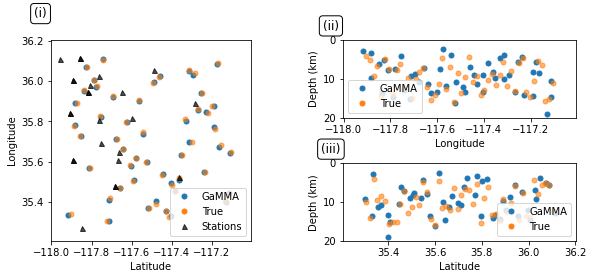

In [56]:
markersize = 10

fig = plt.figure(figsize=plt.rcParams["figure.figsize"] * np.array([1.5, 1]))
box = dict(boxstyle='round', facecolor='white', alpha=1)
text_loc = [-0.05, 1.10]
grd = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[1.5, 1], height_ratios=[1, 1])
fig.add_subplot(grd[:, 0])
plt.plot(
    catalog["longitude"], catalog["latitude"], '.', markersize=markersize, alpha=1.0
)
plt.plot(events["longitude"], events["latitude"], '.', markersize=markersize, alpha=0.6)
plt.axis("scaled")
plt.xlim(np.array(config["xlim_degree"]))  # +np.array([0.2,-0.27]))
plt.ylim(np.array(config["ylim_degree"]))  # +np.array([0.2,-0.27]))
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.gca().set_prop_cycle(None)
plt.plot(
    config["xlim_degree"][0] - 10,
    config["ylim_degree"][0] - 10,
    '.',
    markersize=10,
    label=f"{result_label}",
    rasterized=True,
)
plt.plot(
    config["xlim_degree"][0] - 10,
    config["ylim_degree"][0] - 10,
    '.',
    markersize=10,
    label=f"{catalog_label}",
    rasterized=True,
)
plt.plot(
    stations["longitude"],
    stations["latitude"],
    'k^',
    markersize=5,
    alpha=0.7,
    label="Stations",
)
plt.legend()
plt.text(
    text_loc[0],
    text_loc[1],
    '(i)',
    horizontalalignment='center',
    verticalalignment="bottom",
    transform=plt.gca().transAxes,
    fontsize="large",
    fontweight="normal",
    bbox=box,
)

fig.add_subplot(grd[0, 1])
plt.plot(
    catalog["longitude"],
    catalog["depth(m)"] / 1e3,
    '.',
    markersize=markersize,
    alpha=1.0,
    rasterized=True,
)
plt.plot(
    events["longitude"],
    events["depth(m)"] / 1e3,
    '.',
    markersize=markersize,
    alpha=0.6,
    rasterized=True,
)
# plt.axis("scaled")
plt.xlim(np.array(config["xlim_degree"]))  # +np.array([0.2,-0.27]))
plt.ylim(config["zlim_km"])
plt.gca().invert_yaxis()
plt.xlabel("Longitude")
plt.ylabel("Depth (km)")
plt.gca().set_prop_cycle(None)
plt.plot(config["xlim_degree"][0] - 10, 31, '.', markersize=10, label=f"{result_label}")
plt.plot(31, 31, '.', markersize=10, label=f"{catalog_label}")
plt.legend()
plt.text(
    text_loc[0],
    text_loc[1],
    '(ii)',
    horizontalalignment='center',
    verticalalignment="bottom",
    transform=plt.gca().transAxes,
    fontsize="large",
    fontweight="normal",
    bbox=box,
)

fig.add_subplot(grd[1, 1])
plt.plot(
    catalog["latitude"],
    catalog["depth(m)"] / 1e3,
    '.',
    markersize=markersize,
    alpha=1.0,
    rasterized=True,
)
plt.plot(
    events["latitude"],
    events["depth(m)"] / 1e3,
    '.',
    markersize=markersize,
    alpha=0.6,
    rasterized=True,
)
# plt.axis("scaled")
plt.xlim(np.array(config["ylim_degree"]))  # +np.array([0.2,-0.27]))
plt.ylim(config["zlim_km"])
plt.gca().invert_yaxis()
plt.xlabel("Latitude")
plt.ylabel("Depth (km)")
plt.gca().set_prop_cycle(None)
plt.plot(config["ylim_degree"][0] - 10, 31, '.', markersize=10, label=f"{result_label}")
plt.plot(31, 31, '.', markersize=10, label=f"{catalog_label}")
plt.legend()
plt.tight_layout()
plt.text(
    text_loc[0],
    text_loc[1],
    '(iii)',
    horizontalalignment='center',
    verticalalignment="bottom",
    transform=plt.gca().transAxes,
    fontsize="large",
    fontweight="normal",
    bbox=box,
)
plt.savefig(figure_dir("earthquake_location.png"), bbox_inches="tight", dpi=300)
plt.savefig(figure_dir("earthquake_location.pdf"), bbox_inches="tight", dpi=300)
plt.show()



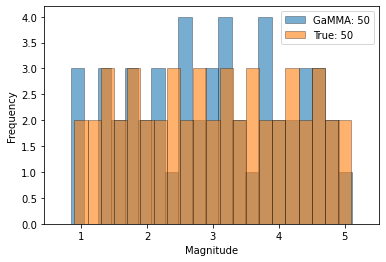

In [57]:
plt.figure()
plt.hist(
    catalog["magnitude"],
    range=(catalog["magnitude"].min() - 0.5, catalog["magnitude"].max() + 0.5),
    bins=25,
    alpha=0.6,
    edgecolor="k",
    linewidth=0.5,
    label=f"{result_label}: {len(catalog['magnitude'])}",
)
plt.hist(
    events["magnitude"],
    range=(events["magnitude"].min() - 0.5, events["magnitude"].max() + 0.5),
    bins=25,
    alpha=0.6,
    edgecolor="k",
    linewidth=0.5,
    label=f"{catalog_label}: {len(events['magnitude'])}",
)
plt.legend()
# plt.figure()
plt.xlim(
    [
        min(events["magnitude"].min(), catalog["magnitude"].min()) - 0.5,
        max(events["magnitude"].max(), catalog["magnitude"].max()) + 0.5,
    ]
)
plt.xlabel("Magnitude")
plt.ylabel("Frequency")
# plt.gca().set_yscale('log')
plt.savefig(
    figure_dir("earthquake_magnitude_frequency.png"), bbox_inches="tight", dpi=300
)
plt.savefig(figure_dir("earthquake_magnitude_frequency.pdf"), bbox_inches="tight")
plt.show()



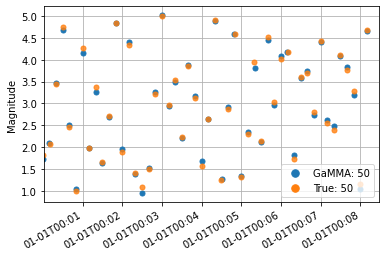

In [58]:
markersize = 10

plt.figure()
plt.plot(
    catalog["time"],
    catalog["magnitude"],
    '.',
    markersize=markersize,
    alpha=1.0,
    rasterized=True,
)
plt.plot(
    events["time"],
    events["magnitude"],
    '.',
    markersize=markersize,
    alpha=0.8,
    rasterized=True,
)
plt.xlim([config["starttime"], config["endtime"]])
ylim = plt.ylim()
plt.ylabel("Magnitude")
# plt.xlabel("Date")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%dT%H:%M'))
plt.gcf().autofmt_xdate()
plt.gca().set_prop_cycle(None)
plt.plot(
    config["starttime"],
    -10,
    '.',
    markersize=15,
    alpha=1.0,
    label=f"{result_label}: {len(catalog['magnitude'])}",
)
plt.plot(
    config["starttime"],
    -10,
    '.',
    markersize=15,
    alpha=1.0,
    label=f"{catalog_label}: {len(events['magnitude'])}",
)
plt.legend()
plt.ylim(ylim)
plt.grid()
plt.savefig(figure_dir("earthquake_magnitude_time.png"), bbox_inches="tight", dpi=300)
plt.savefig(figure_dir("earthquake_magnitude_time.pdf"), bbox_inches="tight", dpi=300)
plt.show()



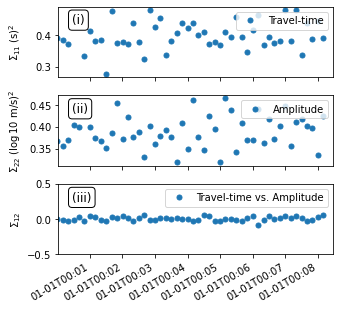

In [59]:
markersize = 10

fig = plt.figure(figsize=plt.rcParams["figure.figsize"] * np.array([0.8, 1.1]))
box = dict(boxstyle='round', facecolor='white', alpha=1)
text_loc = [0.05, 0.90]
plt.subplot(311)
plt.plot(
    catalog["time"], catalog["sigma_time"], '.', markersize=markersize, label="Travel-time"
)
# plt.ylim([0, 3])
plt.xlim([config["starttime"], config["endtime"]])
# plt.ylim([0, 1.0])
plt.ylabel(r"$\Sigma_{11}$ (s)$^2$")
plt.legend(loc="upper right")
plt.text(
    text_loc[0],
    text_loc[1],
    '(i)',
    horizontalalignment='left',
    verticalalignment="top",
    transform=plt.gca().transAxes,
    fontsize="large",
    fontweight="normal",
    bbox=box,
)
plt.subplot(312)
plt.plot(
    catalog["time"], catalog["sigma_amp"], '.', markersize=markersize, label="Amplitude"
)
# plt.ylim([0, 1])
plt.xlim([config["starttime"], config["endtime"]])
# plt.ylim([0, 0.3])
plt.ylabel(r"$\Sigma_{22}$ ($\log10$ m/s)$^2$")
plt.legend(loc="upper right")
plt.text(
    text_loc[0],
    text_loc[1],
    '(ii)',
    horizontalalignment='left',
    verticalalignment="top",
    transform=plt.gca().transAxes,
    fontsize="large",
    fontweight="normal",
    bbox=box,
)
plt.subplot(313)
plt.plot(
    catalog["time"],
    catalog["cov_time_amp"],
    '.',
    markersize=markersize,
    label="Travel-time vs. Amplitude",
)
plt.ylabel(r"$\Sigma_{12}$")
plt.xlim([config["starttime"], config["endtime"]])
plt.ylim([-0.5, 0.5])
plt.legend(loc="upper right")
plt.text(
    text_loc[0],
    text_loc[1],
    '(iii)',
    horizontalalignment='left',
    verticalalignment="top",
    transform=plt.gca().transAxes,
    fontsize="large",
    fontweight="normal",
    bbox=box,
)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%dT%H:%M'))
plt.gcf().autofmt_xdate()
# plt.suptitle(r"Covariance Matrix ($\Sigma$) Coefficients")
plt.tight_layout()
plt.gcf().align_labels()
plt.savefig(figure_dir("covariance.png"), bbox_inches="tight", dpi=300)
plt.savefig(figure_dir("covariance.pdf"), bbox_inches="tight")
plt.show()



In [60]:
print(f"sigma_time = {np.mean(catalog['sigma_time']):.2f}, sigma_amp = {np.mean(catalog['sigma_amp']):.2f}")

sigma_time = 0.40, sigma_amp = 0.39
